#1 Packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomCrop, RandomZoom, RandomContrast


# 1.1 Create the Dataset and Split it into Training and Validation Sets


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "D:\\University\\ArchitectureStyles\\archive\\architectural-styles-dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             label_mode='categorical',
                                             subset='training',

                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             label_mode='categorical',
                                             seed=42)

Found 10112 files belonging to 25 classes.
Using 8090 files for training.
Found 10112 files belonging to 25 classes.
Using 2022 files for validation.


Represent data

In [5]:
# class_names = train_dataset.class_names
# print(len(class_names))
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

# 2 Preprocess and Augment Training Data

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomCrop(height=IMG_SIZE[0], width=IMG_SIZE[1]))
    data_augmentation.add(RandomContrast(factor=0.2))
    return data_augmentation

Augumented images

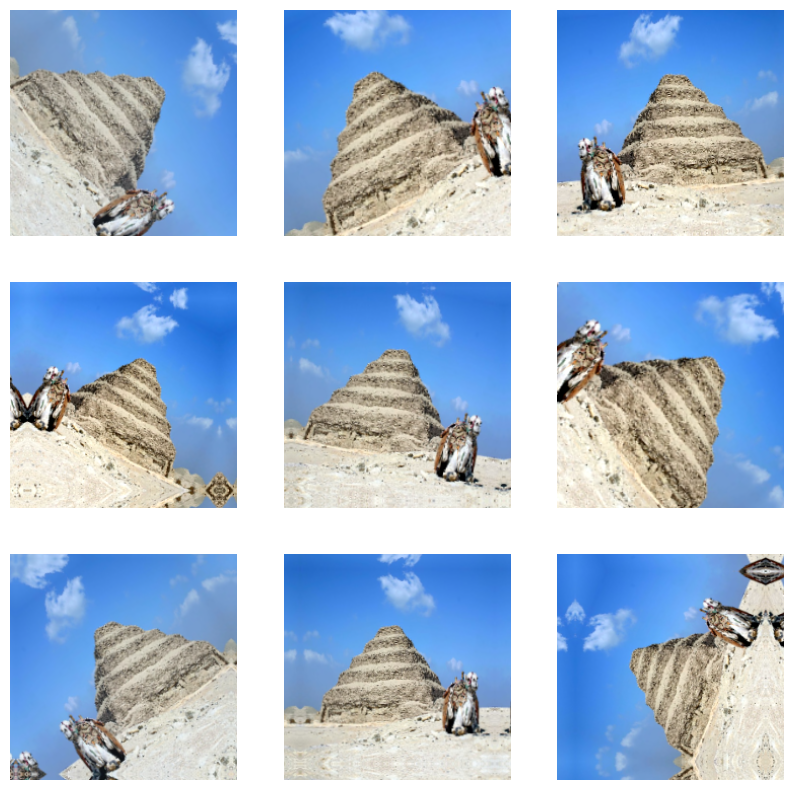

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# 3 Using ResNet50

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
preprocess_input = tf.keras.applications.resnet50.preprocess_input

(32, 1000)


In [13]:
def arc_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(25, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [14]:
model2 = arc_model(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
253/253 [==============================] - 446s 2s/step - loss: 1.9836 - accuracy: 0.4048 - val_loss: 1.5934 - val_accuracy: 0.5257
Epoch 2/10
253/253 [==============================] - 751s 3s/step - loss: 1.5096 - accuracy: 0.5266 - val_loss: 1.5290 - val_accuracy: 0.5218
Epoch 3/10
253/253 [==============================] - 960s 4s/step - loss: 1.3973 - accuracy: 0.5533 - val_loss: 1.3913 - val_accuracy: 0.5737
Epoch 4/10
253/253 [==============================] - 950s 4s/step - loss: 1.2854 - accuracy: 0.5964 - val_loss: 1.5297 - val_accuracy: 0.5272
Epoch 5/10
253/253 [==============================] - 970s 4s/step - loss: 1.2160 - accuracy: 0.6132 - val_loss: 1.4606 - val_accuracy: 0.5673
Epoch 6/10
253/253 [==============================] - 963s 4s/step - loss: 1.1483 - accuracy: 0.6326 - val_loss: 1.5192 - val_accuracy: 0.5495
Epoch 7/10
253/253 [==============================] - 826s 3s/step - loss: 1.0937 - accuracy: 0.6444 - val_loss: 1.4049 - val_accuracy: 0.5781

Results

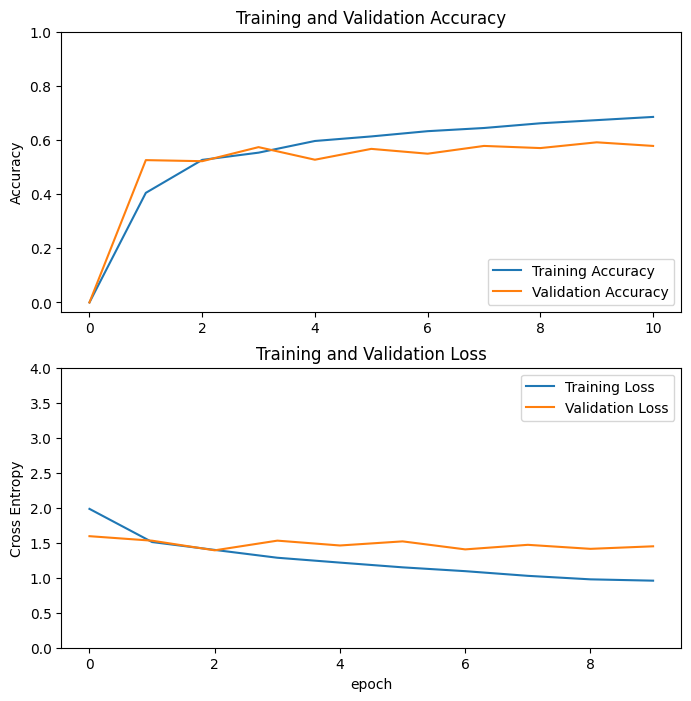

In [15]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Number of layers in the base model:  175
Epoch 10/15
253/253 [==============================] - 759s 3s/step - loss: 1.0636 - accuracy: 0.6593 - val_loss: 1.3060 - val_accuracy: 0.5880
Epoch 11/15
253/253 [==============================] - 637s 3s/step - loss: 0.8371 - accuracy: 0.7321 - val_loss: 1.2412 - val_accuracy: 0.6429
Epoch 12/15
253/253 [==============================] - 637s 3s/step - loss: 0.6926 - accuracy: 0.7768 - val_loss: 1.3507 - val_accuracy: 0.6103
Epoch 13/15
253/253 [==============================] - 647s 3s/step - loss: 0.5959 - accuracy: 0.8068 - val_loss: 1.2374 - val_accuracy: 0.6568
Epoch 14/15
253/253 [==============================] - 660s 3s/step - loss: 0.5277 - accuracy: 0.8321 - val_loss: 1.2851 - val_accuracy: 0.6543
Epoch 15/15
253/253 [==============================] - 661s 3s/step - loss: 0.4433 - accuracy: 0.8556 - val_loss: 1.4237 - val_accuracy: 0.6281


Results

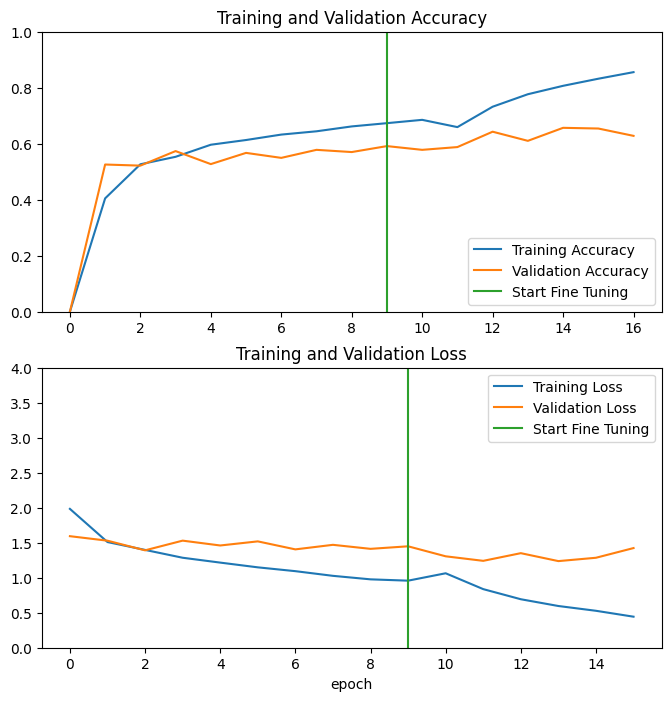

In [17]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
model_name = "tf_architecture_keras_resnet.v2"
model2.save(f"models/{model_name}.h5")

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('models/arcitec_resnetv1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Temp\tmpm_2p7ovj\assets


INFO:tensorflow:Assets written to: C:\Temp\tmpm_2p7ovj\assets
